In [1]:
import numpy as np
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, plot_gradient, dlla_hw, p_gradient_dl_la, encode
from src.tools.plotter import init_plots
from src.tvla.accu import TvlaAccu
from src.tvla.t import make_t_test

init_plots()

In [2]:
ascad = AscadRandomKey().default

x_prof, y_prof, x_att, y_att = fetch_traces(ascad)
y_att_unmasked = encode(ascad.attack.unmasked_labels())

### Model creation

With model hyperparameters to be optimized.

In [3]:
model_parameters = {
    'activation': ['relu'],
    'optimizer': [Adam(lr=0.001)],
    'losses': ['categorical_crossentropy'],
    'batch_size': list(np.linspace(100, 300, 5).astype(int)),
    'epochs': list(np.linspace(5, 20, 4).astype(int))
}

def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [4]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [5]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [6]:
best_model.predict(x_att[:1])[0]

array([0.00335237, 0.02744355, 0.09591824, 0.18788299, 0.24041061,
       0.23835193, 0.14476623, 0.05262682, 0.00924732], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [7]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

4.247294690459967

In [8]:
dlla_hw(best_model, x_att, y_att)

(0.0, 0.36536742913633347)

### Plot prediction distribution for all traces.

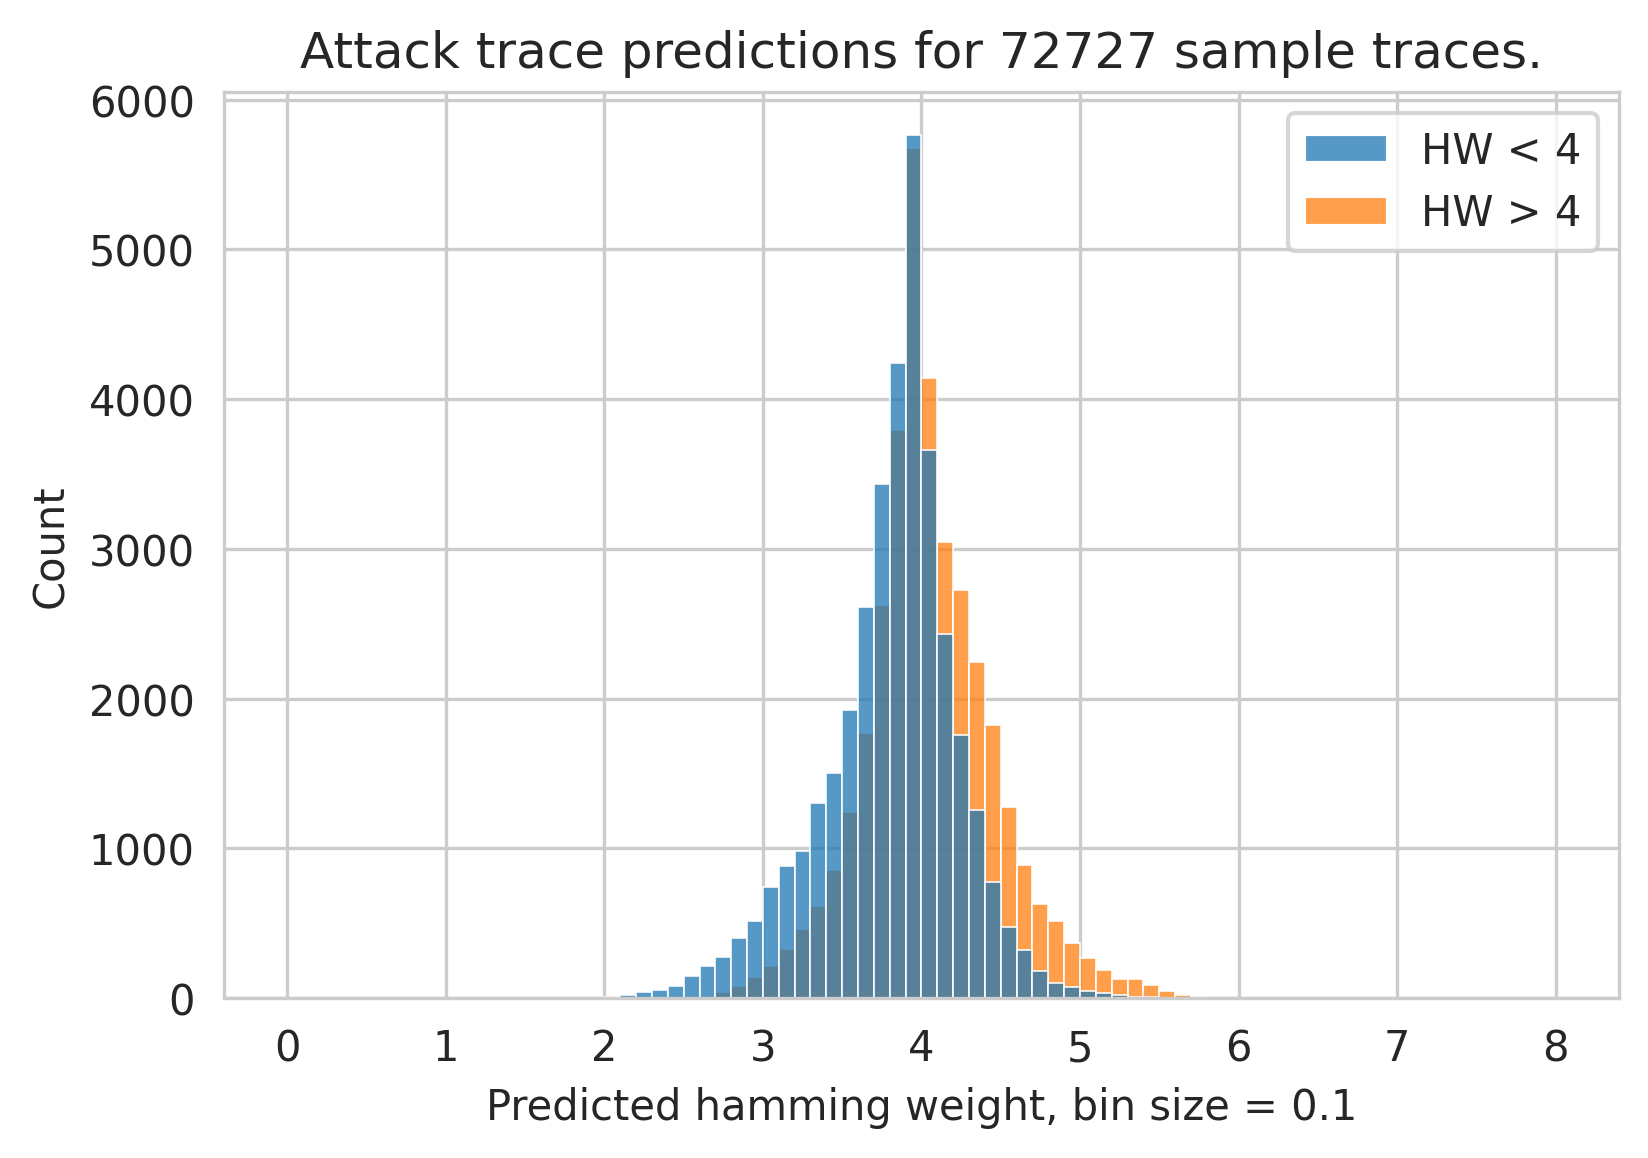

In [9]:
plot_predictions(best_model, x_att, y_att)

### Plot p-gradient.

In [10]:
def split_traces(x, y):
    yam = np.argmax(y, axis=1)
    a = x[np.where(yam < 4)]
    b = x[np.where(yam > 4)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(x_att, y_att_unmasked)

In [14]:
def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    accumulator = TvlaAccu(a.shape[1], make_test=make_t_test)
    accumulator.add(a, b)

    return accumulator.p_gradient

TVLA_MIN_P = min_p_gradient(A_ATT, B_ATT)

Running t-tests:   0%|          | 0/36307 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:22: RuntimeWarning: divide by zero encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:22: RuntimeWarning: invalid value encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:24: RuntimeWarning: invalid value encountered in true_divide
  dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)
Running t-tests: 100%|██████████| 36307/36307 [00:29<00:00, 1245.31it/s]


In [34]:
PG_DLLA = p_gradient_dl_la(best_model, x_att, y_att, 1000)["A vs. B"]

TypeError: only integer scalar arrays can be converted to a scalar index

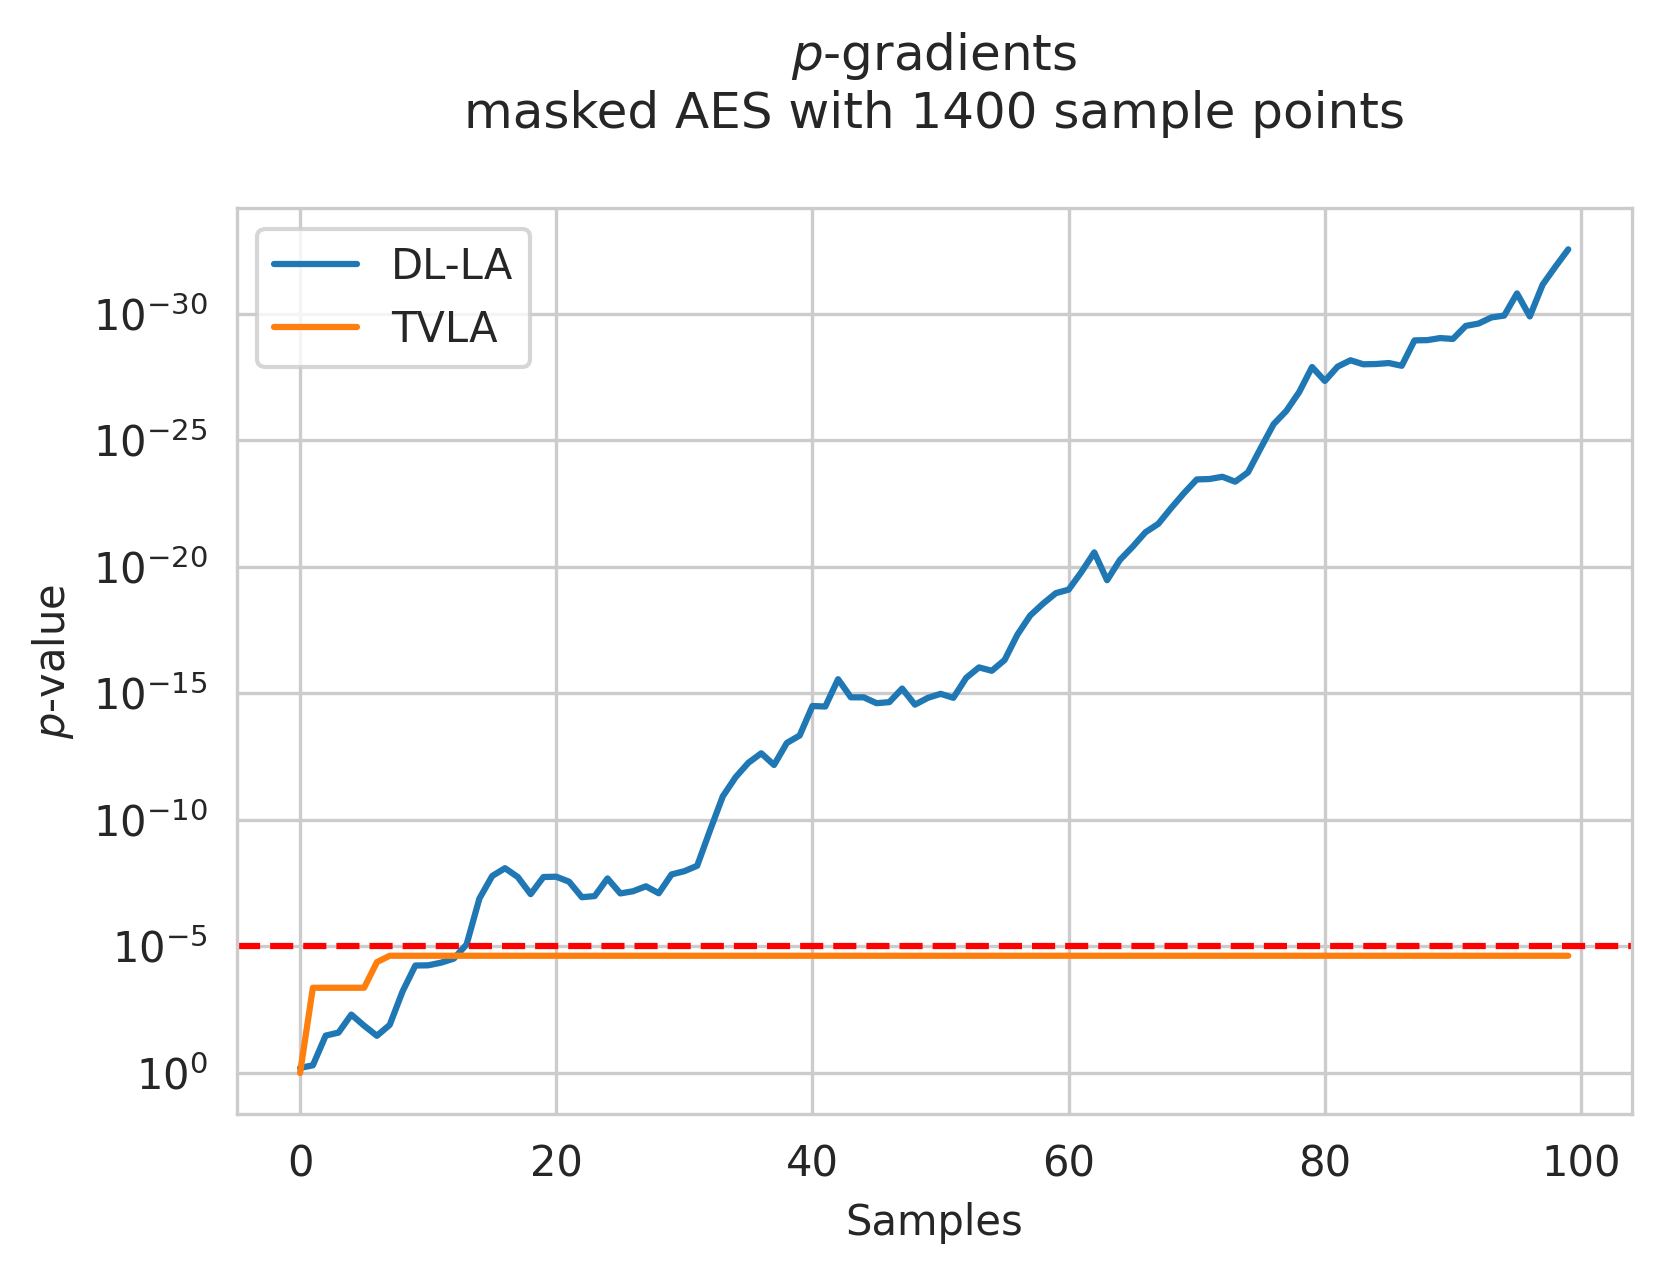

In [45]:
g = sns.lineplot(data={
    "DL-LA": np.array(PG_DLLA),
    "TVLA": np.array(TVLA_MIN_P)[PG_DLLA.index]
})

g.set(yscale="log", xlabel="Samples", ylabel="$p$-value",
      title="$p$-gradients\nmasked AES with 1400 sample points\n")
g.invert_yaxis()
[l.set_linestyle('-') for l in g.lines]
g.legend()

g.axhline(10 ** -5, ls='--', color="red")